In [1]:
import torch
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_all(train_df, s_times = 10, r_times=2, figsize = (18, 6)):

    figure, axis = plt.subplots(r_times, s_times, figsize=figsize)

    for r_id in range(r_times):
        for s_id in range(s_times):
            temp_df = train_df[(train_df['s_id']==s_id) &
                               (train_df['r_id']==r_id)]
            temp_df.plot(y=['train_loss', 'train_acc'], x='epoch', ax=axis[r_id, s_id])
            axis[r_id, s_id].set_title(f'r_id:{r_id}, s_id:{s_id}')
            #temp_df.plot(y=['train_loss'], x='epoch', ax=axis[r_id, s_id])
    plt.show()

def e_f_given_sr(prob_df, s_id, r_id, label =0):
    # E_{X,Y}[f(r,S,X,Y)]
    # E_{X}[f(r,S,X,y_i)] when label is given

    if label is not None:
        temp_df = prob_df[(prob_df['r_id'] == r_id) & (prob_df['s_id']==s_id) & (prob_df['label']==label)]
    else:
        temp_df =  prob_df[(prob_df['r_id'] == r_id) & (prob_df['s_id']==s_id)]
    e_f = temp_df['loss'].mean()
    return e_f

def e_f_given_r(prob_df, r_id, label = 0):
    s_ids = list(prob_df['s_id'].unique())
    e_f = []
    for s_id in s_ids:
        e_f.append(e_f_given_sr(prob_df, s_id, r_id, label))
    
    print(f'Exp_(s,x)[f(s,x,{label})] = ',np.mean(e_f))

    return np.mean(e_f)

def e_f(prob_df, label = 0):
    r_ids = list(prob_df['r_id'].unique())
    e_f = []
    for r_id in r_ids:
        e_f.append(e_f_given_r(prob_df, r_id, label))

    print(f'Exp_(r,s,x)[f(s,x,{label})] = ',np.mean(e_f))
    return e_f

def var_f_given_r(prob_df, r_id):
    # Var_{S}[ E_{X,Y}[ f(r,S,X,Y) ] ]
    s_ids = list(prob_df['s_id'].unique())
    f_op = []
    for s_id in s_ids:
        f_op.append(e_f_given_sr(prob_df, s_id, r_id, label=None))
    
    return np.var(f_op)

def var_f(prob_df):
    r_ids = list(prob_df['r_id'].unique())
    var_f_op = []
    for r_id in r_ids:
        var_f_op.append(var_f_given_r(prob_df, r_id))
    
    return var_f_op

def var_risk_given_r_by_m(prob_df, r_id, m_list = None):
    ## Var_{S}(E_{X,y}[f(r,S,X,Y)]) given r grouped by |S| = m
    if m_list is None:
        m_list = prob_df['m'].unique()
    e_f = []
    for m in m_list:
        e_f.append(var_f_given_r(prob_df[prob_df['m'] == m], r_id))

    return e_f

def var_risk_multiple_exp(prob_df):
    r_ids = list(prob_df['r_id'].unique())
    m_list = list(prob_df['m'].unique())
    var_exp_wise = []
    for r_id in r_ids:
        var_exp_wise.append(var_risk_given_r_by_m(prob_df, r_id, m_list))

    return var_exp_wise, m_list


def get_var_df(prob_df):
    # given for every m,r_id it gives max_{z} Var_{S}[f(r,S,z)]

    z_ids = prob_df['z_id'].unique()
    r_ids = prob_df['r_id'].unique()
    m_list = prob_df['m'].unique()


    var_s_dict = {}
    var_s_dict['r_id'] = []
    var_s_dict['m'] = []
    var_s_dict['var_s_given_mr'] = []

    for r_id in r_ids:
        for m in m_list: 
            temp_prob_df = prob_df[(prob_df['r_id']==r_id) & (prob_df['m']==m)]
            var_s_given_zmr = []
            for z_id in z_ids:
                s_times = temp_prob_df[temp_prob_df['z_id']==z_id]['loss'].shape
                #print(f's_times:{s_times}?')
                var_s_given_zmr.append(temp_prob_df[temp_prob_df['z_id']==z_id]['loss'].var())
            var_s_given_mr = max(var_s_given_zmr)
            var_s_dict['r_id'].append(r_id)
            var_s_dict['m'].append(m)
            var_s_dict['var_s_given_mr'].append(var_s_given_mr)
    
    var_s_df = pd.DataFrame(var_s_dict)
    return var_s_df



# Calculating Variance for lower bounding lipschitz constant

### exp trial

In [10]:
train_file = 'results/exp_mnist_l16/train_file.csv'

train_df = pd.read_csv(train_file)
train_df

,r_id,s_id,epoch,train_loss,train_acc
0,0,0,0,0.692592,0.59
1,0,0,1,0.690297,0.59
2,0,0,2,0.690059,0.59
3,0,0,3,0.688338,0.59
4,0,0,4,0.686219,0.59
...,...,...,...,...,...
3995,1,9,195,0.344598,0.85
3996,1,9,196,0.346777,0.85
3997,1,9,197,0.342641,0.85
3998,1,9,198,0.361398,0.85


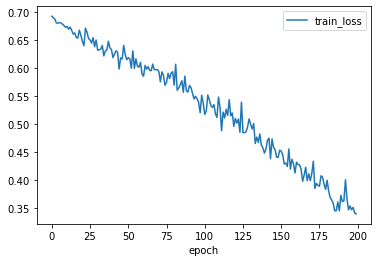

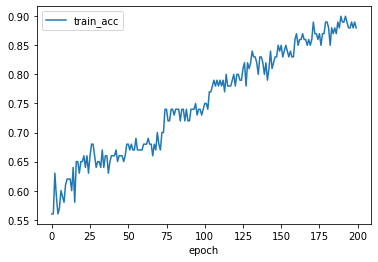

In [11]:
temp_df = train_df[(train_df['r_id'] == 1) & (train_df['s_id'] ==2)]

loss_list = temp_df.plot(y=['train_loss'], x='epoch')
plt.show()
loss_list = temp_df.plot(y=['train_acc'], x='epoch')


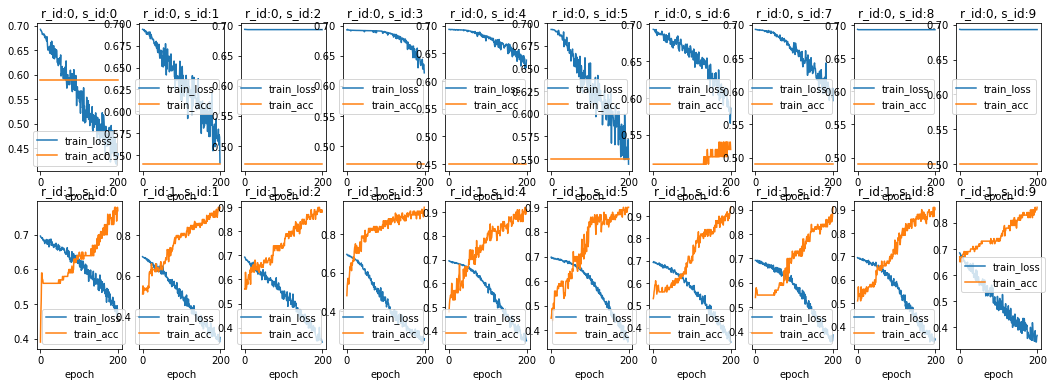

In [12]:

plot_all(train_df)

### exp_mnist_l32_e400_r5

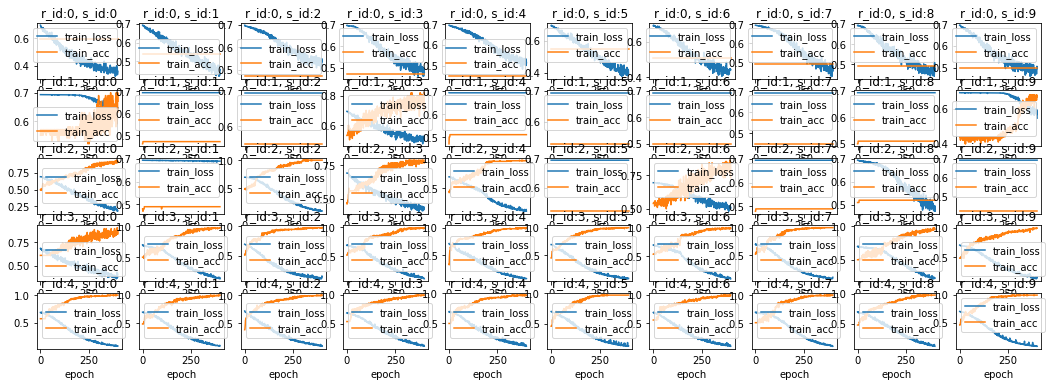

In [13]:
train_file = 'results/exp_mnist_lr32_e400_r5/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df, s_times=10, r_times=5)

In [14]:
# problem prob
prob_file = 'results/exp_mnist_lr32_e400_r5/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=5)
prob_df

,r_id,s_id,z_id,loss,label
NaN,0,0,1397,7.672353,1
NaN,0,0,1397,0.693147,1
NaN,0,0,1397,0.100302,0
NaN,0,0,1397,0.987034,1
NaN,0,0,1397,3.294757,1
...,...,...,...,...,...
NaN,4,9,2642,1.156655,1
NaN,4,9,2642,0.375454,0
NaN,4,9,2642,0.570994,0
NaN,4,9,2642,3.136919,0


In [21]:
e_f(prob_df, label=0)

e_f(prob_df, label=1)


Exp_(s,x)[f(s,x,0)] =  0.3946807281671916
Exp_(s,x)[f(s,x,0)] =  0.8117735108149695
Exp_(s,x)[f(s,x,0)] =  0.9984904610391332
Exp_(s,x)[f(s,x,0)] =  1.168662728913032
Exp_(s,x)[f(s,x,0)] =  1.3163250653228438
Exp_(r,s,x)[f(s,x,0)] =  0.937986498851434
Exp_(s,x)[f(s,x,1)] =  1.5034680786530945
Exp_(s,x)[f(s,x,1)] =  0.6432408794141733
Exp_(s,x)[f(s,x,1)] =  0.9722567849447572
Exp_(s,x)[f(s,x,1)] =  1.322370025567539
Exp_(s,x)[f(s,x,1)] =  1.2375636462734934
Exp_(r,s,x)[f(s,x,1)] =  1.1357798829706112


### exp_mnist_l32_r20_s20_e500

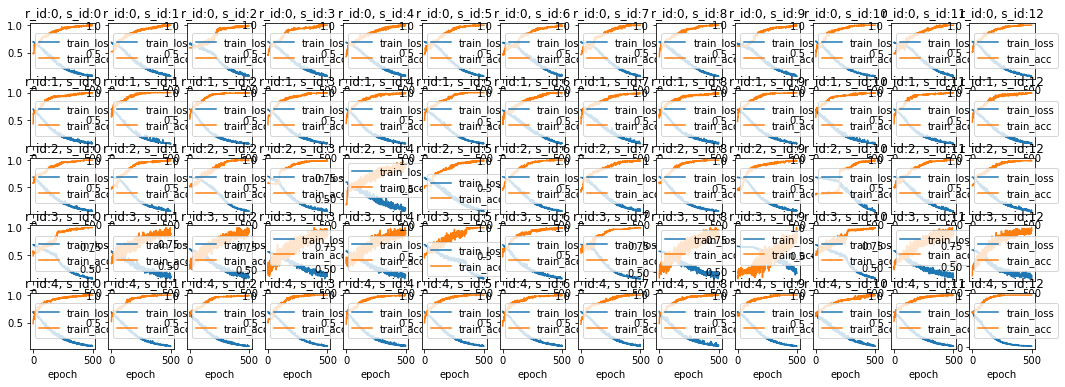

In [3]:
train_file = 'results/exp_mnist_l32_r20_s20_e500/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df, s_times=13, r_times=5)

In [4]:
prob_file = 'results/exp_mnist_l32_r20_s20_e500/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=5)
prob_df

,r_id,s_id,z_id,loss,label
NaN,0,0,1915,0.001484,1
NaN,0,0,4362,0.025338,0
NaN,0,0,8398,1.143271,1
NaN,0,0,10472,0.045185,0
NaN,0,0,12587,5.432092,1
...,...,...,...,...,...
NaN,19,19,5302,0.693147,0
NaN,19,19,12628,0.386658,0
NaN,19,19,12657,0.693147,1
NaN,19,19,3518,1.802176,1


Exp_(s,x)[f(s,x,0)] =  1.5097819519170843
Exp_(s,x)[f(s,x,0)] =  1.2476424793624836
Exp_(s,x)[f(s,x,0)] =  1.4436701720622396
Exp_(s,x)[f(s,x,0)] =  1.7568882116019473
Exp_(s,x)[f(s,x,0)] =  1.5399407618526761
Exp_(s,x)[f(s,x,0)] =  1.661899158396612
Exp_(s,x)[f(s,x,0)] =  1.581285584418474
Exp_(s,x)[f(s,x,0)] =  1.389623411601808
Exp_(s,x)[f(s,x,0)] =  1.1121238319763036
Exp_(s,x)[f(s,x,0)] =  1.3690821721076083
Exp_(s,x)[f(s,x,0)] =  1.8643192122698065
Exp_(s,x)[f(s,x,0)] =  1.6702665256308786
Exp_(s,x)[f(s,x,0)] =  0.6589508728250728
Exp_(s,x)[f(s,x,0)] =  1.2025972459800902
Exp_(s,x)[f(s,x,0)] =  1.0566592324032573
Exp_(s,x)[f(s,x,0)] =  0.8067996714685298
Exp_(s,x)[f(s,x,0)] =  1.5419379536691213


Exp_(s,x)[f(s,x,0)] =  1.7325242103763834
Exp_(s,x)[f(s,x,0)] =  1.5871455811864332
Exp_(s,x)[f(s,x,0)] =  0.3703717181482408
Exp_(r,s,x)[f(s,x,0)] =  1.3551754979627524
Exp_(s,x)[f(s,x,1)] =  1.2472416176469756
Exp_(s,x)[f(s,x,1)] =  1.5530280627993516
Exp_(s,x)[f(s,x,1)] =  1.4093297178553659
Exp_(s,x)[f(s,x,1)] =  0.7324078498168318
Exp_(s,x)[f(s,x,1)] =  1.5944694028567632
Exp_(s,x)[f(s,x,1)] =  0.4159866280452557
Exp_(s,x)[f(s,x,1)] =  1.4198297118232215
Exp_(s,x)[f(s,x,1)] =  1.5936134852110162
Exp_(s,x)[f(s,x,1)] =  1.5117471927565669
Exp_(s,x)[f(s,x,1)] =  1.4916554180793082
Exp_(s,x)[f(s,x,1)] =  1.3604707996794458
Exp_(s,x)[f(s,x,1)] =  1.3963130756656954
Exp_(s,x)[f(s,x,1)] =  1.3300539070628061
Exp_(s,x)[f(s,x,1)] =  1.2884638974593081
Exp_(s,x)[f(s,x,1)] =  1.4324794464448367
Exp_(s,x)[f(s,x,1)] =  1.6140415002999071
Exp_(s,x)[f(s,x,1)] =  1.3177464710614768
Exp_(s,x)[f(s,x,1)] =  1.2517442336826705
Exp_(s,x)[f(s,x,1)] =  1.5582049118394616
Exp_(s,x)[f(s,x,1)] =  1.5995113

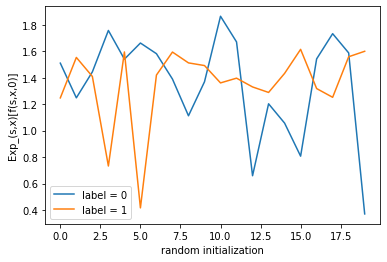

In [5]:
plt.plot(e_f(prob_df, label=0), label='label = 0')
plt.plot(e_f(prob_df, label=1), label='label = 1')
plt.ylabel('Exp_(s,x)[f(s,x,0)]')
plt.xlabel('random initialization')
plt.legend()


Text(0.5, 1.0, 'Var_S(f) for different randomness')

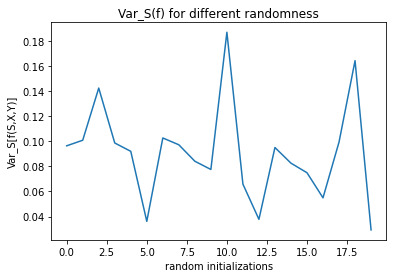

In [6]:
plt.plot(var_f(prob_df))
plt.ylabel('Var_S[f(S,X,Y)]')
plt.xlabel('random initializations')
plt.title('Var_S(f) for different randomness')

#### Plot for any given random initialization

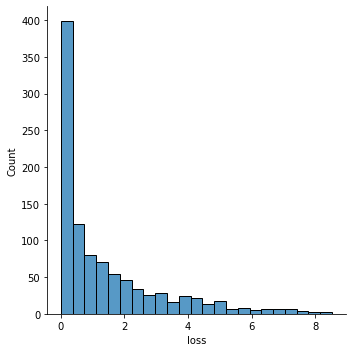

In [7]:
# plt.hist(prob_df[prob_df['r_id'] == 1]['loss'].to_list(), bins=50)

prob_df_indexed = prob_df.reset_index(drop=True)
sns.displot(prob_df_indexed[prob_df_indexed['r_id'] ==1], x='loss')#, hue='s_id', element='step')

#### Plot for all random initializations

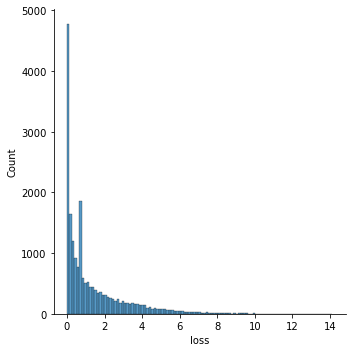

In [79]:
prob_df_indexed = prob_df.reset_index(drop=True)
sns.displot(prob_df_indexed, x='loss')#, hue='s_id', element='step')

### exp_gminst_l32_r50_s50_e500

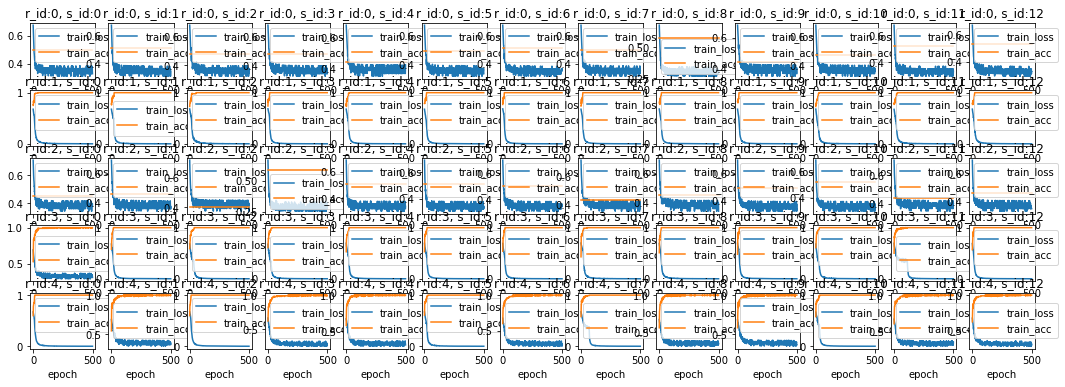

In [80]:
train_file = 'results/exp_gmnist_l32_r50_s50_e500/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df, s_times=13, r_times=5)

In [84]:
prob_file = 'results/exp_gmnist_l32_r50_s50_e500/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=None)
prob_df

,r_id,s_id,z_id,loss,label
0,0,0,2711,0.000065,0
1,0,0,2482,0.693147,1
2,0,0,6905,0.000133,0
3,0,0,574,0.693147,1
4,0,0,1207,0.693147,1
...,...,...,...,...,...
9025,6,0,6768,0.693147,1
9026,6,0,4912,0.693147,0
9027,6,0,4055,0.693147,1
9028,6,0,7759,0.693147,1


Exp_(s,x)[f(s,x,0)] =  0.003534386681276137
Exp_(s,x)[f(s,x,0)] =  0.010051352889675493
Exp_(s,x)[f(s,x,0)] =  0.002968266606518307
Exp_(s,x)[f(s,x,0)] =  0.14006962702687406
Exp_(s,x)[f(s,x,0)] =  0.5915706240127961
Exp_(s,x)[f(s,x,0)] =  0.030161751273384555
Exp_(s,x)[f(s,x,0)] =  nan
Exp_(r,s,x)[f(s,x,0)] =  nan
Exp_(s,x)[f(s,x,1)] =  0.7300033824927609
Exp_(s,x)[f(s,x,1)] =  0.0066343421436809305
Exp_(s,x)[f(s,x,1)] =  0.7362901057495199
Exp_(s,x)[f(s,x,1)] =  0.004670530024570152
Exp_(s,x)[f(s,x,1)] =  0.0029727786718444647
Exp_(s,x)[f(s,x,1)] =  0.009193721707622058
Exp_(s,x)[f(s,x,1)] =  nan
Exp_(r,s,x)[f(s,x,1)] =  nan


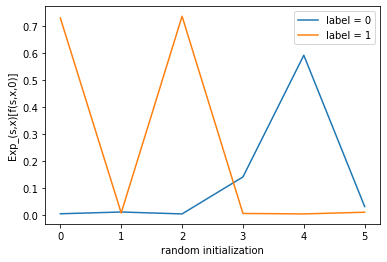

In [85]:
plt.plot(e_f(prob_df, label=0), label='label = 0')
plt.plot(e_f(prob_df, label=1), label='label = 1')
plt.ylabel('Exp_(s,x)[f(s,x,0)]')
plt.xlabel('random initialization')
plt.legend()

Text(0.5, 1.0, 'Var_S(f) for different randomness')

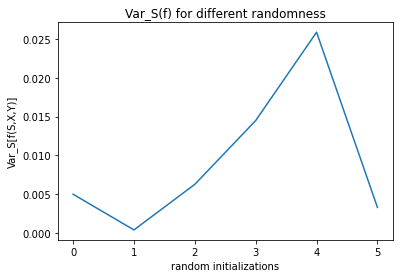

In [86]:
plt.plot(var_f(prob_df))
plt.ylabel('Var_S[f(S,X,Y)]')
plt.xlabel('random initializations')
plt.title('Var_S(f) for different randomness')

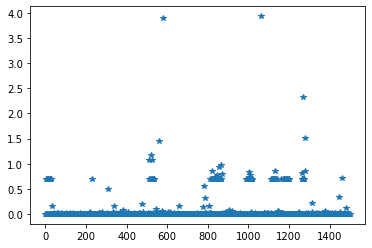

In [98]:
# sns.displot(prob_df[prob_df['r_id'] == 3]['loss'].to_list())
plt.plot(prob_df[prob_df['r_id'] == 3]['loss'].to_list(),'*' )

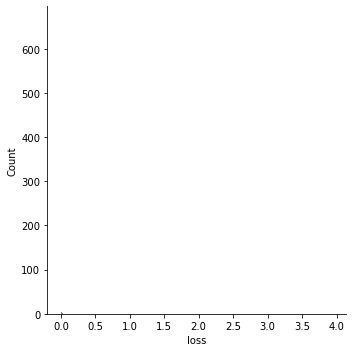

In [101]:
prob_df_indexed = prob_df
sns.displot(prob_df_indexed[prob_df_indexed['r_id'] ==3], x='loss')#, hue='s_id', element='step')

In [ ]:
prob_df_indexed = prob_df.reset_index(drop=True)
sns.displot(prob_df_indexed, x='loss')#, hue='s_id', element='step')

### exp_mnist_l32_8_r20_s20_e400

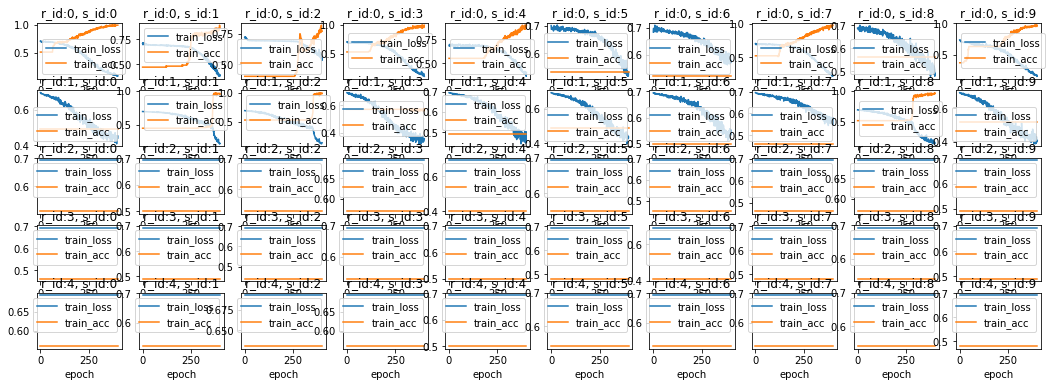

In [49]:
train_file = 'results/exp_mnist_l32_8_r20_s20_e400/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df, s_times=10, r_times=5)

### exp_l32_r50_s50_e500_step_loss

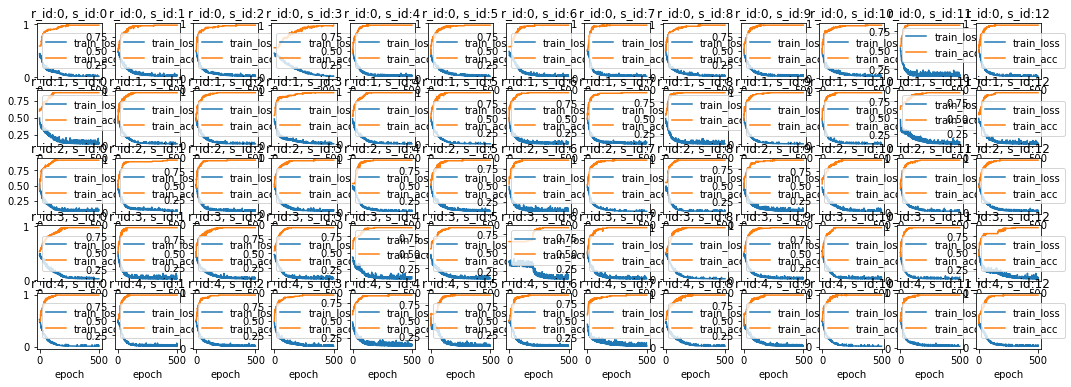

,r_id,s_id,epoch,train_loss,train_acc
0,0,0,0,0.446000,0.59
1,0,0,1,0.395101,0.59
2,0,0,2,0.442948,0.59
3,0,0,3,0.377608,0.59
4,0,0,4,0.392930,0.59
...,...,...,...,...,...
395,0,0,395,0.021833,0.98
396,0,0,396,0.048697,0.98
397,0,0,397,0.022118,0.98
398,0,0,398,0.023044,0.98


In [5]:
train_file = 'results/exp_mnist_l32_r50_s50_e500_step_loss/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df, s_times=13, r_times=5)

,r_id,s_id,z_id,loss,label
0,0,0,4702,1.000000,1
1,0,0,7658,0.000005,1
2,0,0,12462,0.000516,0
3,0,0,6199,0.000008,1
4,0,0,9589,0.999859,1
...,...,...,...,...,...
74995,49,49,5521,0.000002,1
74996,49,49,10234,0.999971,0
74997,49,49,931,0.000000,1
74998,49,49,2269,0.044913,0


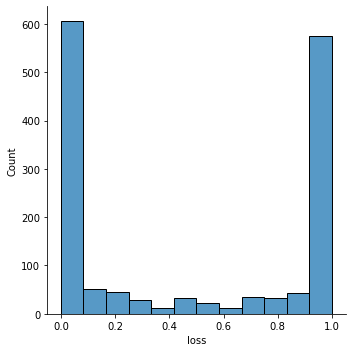

In [8]:
prob_file = 'results/exp_mnist_l32_r50_s50_e500_step_loss/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=None)

sns.displot(prob_df[prob_df['r_id'] ==3], x='loss')#, hue='s_id', element='step')
prob_df

In [7]:
# P_{S,X}[f(r,S,X,0) = M]

def prob_sx_given_r(prob_df, r_id, label =0, threshold= 0.5):

    temp_df = prob_df[(prob_df['r_id']==r_id) & (prob_df['label'] == label)]
    count = (temp_df['loss'] > threshold).sum()
    total = temp_df.shape[0]
    # print(f'count: {count}, total:{total}')
    return (1.0*count)/total

def get_alpha1(prob_df, r_ids, label= 0, threshold =0.9):

    up_bound = 0
    for r_id in r_ids:
        temp = prob_sx_given_r(prob_df, r_id, label=label, threshold=threshold)
        if temp > up_bound:
            up_bound =temp
    return up_bound

def get_alpha2(prob_df, r_ids, label= 0, threshold=0.9):

    lo_bound = prob_df.shape[0]
    for r_id in r_ids:
        temp = prob_sx_given_r(prob_df, r_id, label=label, threshold=threshold)
        if temp < lo_bound:
            lo_bound =temp
    return lo_bound

def get_alpha3(prob_df,r_ids, label =0):

    lo_bound = prob_df.shape[0]
    for r_id in r_ids:
        f_g_sr = []
        s_ids = prob_df[prob_df['r_id'] == r_id]['s_id'].unique()
        for s_id in s_ids:
            f_g_sr.append(e_f_given_sr(prob_df, s_id, r_id, label=label))
       
        ef_g_r = np.mean(f_g_sr)
        # print('ef_given_r', ef_g_r)
        if lo_bound > ef_g_r:
            lo_bound = ef_g_r
    return lo_bound

def var_bound(alpha_1, alpha_2, alpha_3, M, num_classes = 2):
    var_lb = (M*alpha_2)**2/num_classes + 2* alpha_3 - (M*alpha_1)**2
    # print('var_lb', var_lb)
    return var_lb

def show_multiple_var_bound(prob_df, exp_times = 7):
    all_r_ids = prob_df['r_id'].unique()
    r_ids_len = all_r_ids.shape[0]//exp_times
    print('len of r_ids',r_ids_len)

    r_ids_set = np.zeros((exp_times, r_ids_len), dtype=np.long)
    idx = 0
    for i in range(exp_times):
        
        for j in range(r_ids_len):
            # r_ids_set[i].append(all_r_ids[i*exp_times + j])
            r_ids_set[i][j] = int(all_r_ids[i*exp_times + j])
            idx+=1

    var_lb_list = []
    alpha_1_list = []
    alpha_2_list = []
    alpha_3_list = []
    for r_ids in r_ids_set:
        # print('r_ids',r_ids)
        alpha_1 = min(get_alpha1(prob_df,r_ids,label=0), get_alpha1(prob_df,r_ids,label=1))
        alpha_2 = min(get_alpha2(prob_df,r_ids,label=0), get_alpha2(prob_df,r_ids,label=1))
        alpha_3 = min(get_alpha3(prob_df,r_ids,label=0), get_alpha3(prob_df,r_ids,label=1))

        alpha_1_list.append(alpha_1)
        alpha_2_list.append(alpha_2)
        alpha_3_list.append(alpha_3)
        
        var_lb = var_bound(alpha_1, alpha_2, alpha_3,M=1, num_classes=2)
        var_lb_list.append(var_lb)
        # print('Var lb',var_lb)
    
    return var_lb_list, alpha_1_list, alpha_2_list, alpha_3_list

         

In [100]:
alpha_1 = get_alpha1(prob_df, [1,2,3,4,5,6], label=0, threshold=0.9)
print('alpha_1', alpha_1)
print()
alpha_2 = get_alpha2(prob_df, [1,2,3,4,5,6], label=0, threshold=0.9)
print('alpha_2', alpha_2)
alpha_3 = get_alpha3(prob_df, [1,2,3,4,5,6], label=0)
print('alpha_3', alpha_3)

type(alpha_1)

alpha_1 0.44339622641509435

alpha_2 0.3632596685082873
alpha_3 0.4670664757553775


numpy.float64

len of r_ids 7


/tmp/ipykernel_41378/716470972.py:54: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r_ids_set = np.zeros((exp_times, r_ids_len), dtype=np.long)


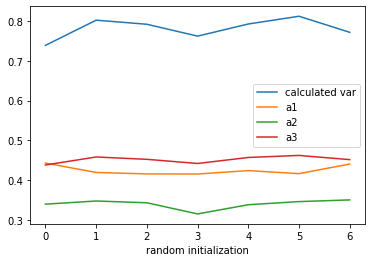

In [101]:
var_lb_list, a1_list, a2_list, a3_list = show_multiple_var_bound(prob_df, 7)

plt.plot(var_lb_list, label = 'calculated var')
plt.plot(a1_list, label = 'a1')
plt.plot(a2_list, label='a2')
plt.plot(a3_list, label = 'a3')
# plt.plot(np.zeros_like(var_lb_list))
plt.xlabel('random initialization')
plt.legend()
plt.show()

### ex2.1_mnist_l32_r50_s50_sloss

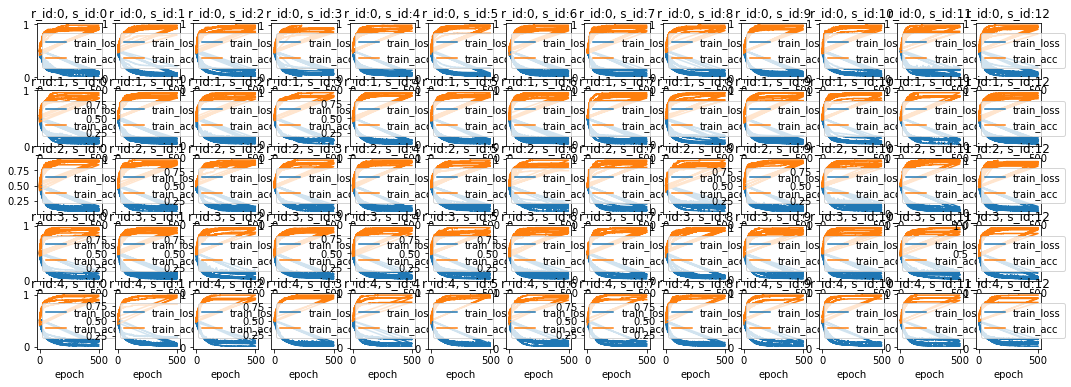

,r_id,s_id,epoch,train_loss,train_acc
0,0,0,0,0.446000,0.590
1,0,0,1,0.395101,0.590
2,0,0,2,0.442948,0.590
3,0,0,3,0.377608,0.590
4,0,0,4,0.392930,0.590
...,...,...,...,...,...
781575,4,20,413,0.072028,0.932
781576,4,20,414,0.072047,0.932
781577,4,20,415,0.074282,0.932
781578,4,20,416,0.069730,0.932


In [6]:
train_file = 'results/ex2.1_mnist_l32_r50_s50_sloss/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df, s_times=13, r_times=5)
train_df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,r_id,m,s_id,z_id,loss,label
0,0,100,0,0,1.000000,1
1,0,100,0,1,0.000005,1
2,0,100,0,2,0.000516,0
3,0,100,0,3,0.000008,1
4,0,100,0,4,0.999859,1
...,...,...,...,...,...,...
49075,4,300,35,25,0.001748,1
49076,4,300,35,26,0.999835,0
49077,4,300,35,27,0.993888,0
49078,4,300,35,28,0.000014,0


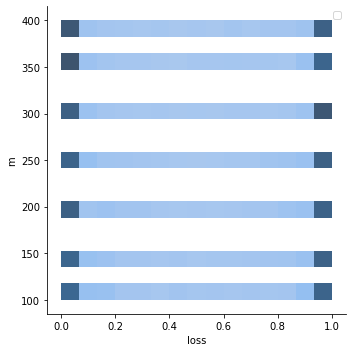

In [46]:
prob_file = 'results/ex2.1_mnist_l32_r50_s50_sloss/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=None)

sns.displot(prob_df[(prob_df['r_id'] ==3)], x='loss', y='m')#, hue='m', element='step')
plt.legend()
prob_df

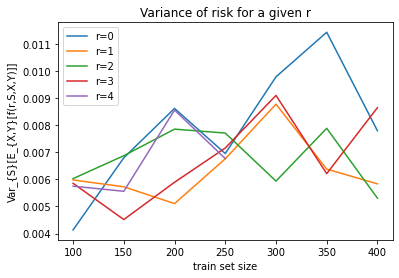

In [53]:
m_list = prob_df['m'].unique()
var_by_m = {}
r_ids = prob_df['r_id'].unique()
for r_id in r_ids:
    var_by_m[r_id] = var_risk_given_r_by_m(prob_df, r_id=r_id, m_list= m_list)
    plt.plot(m_list, var_by_m[r_id], label=f'r={r_id}')

plt.legend()
plt.xlabel('train set size')
plt.ylabel('Var_{S}[E_{X,Y}[f(r,S,X,Y)]]')
plt.title('Variance of risk for a given r')
# plt.savefig('results/ex2.1_mnist_l32_r50_s50_sloss/var_risk_given_r.png')


### ex1_minst_l32_z50_s10_r10

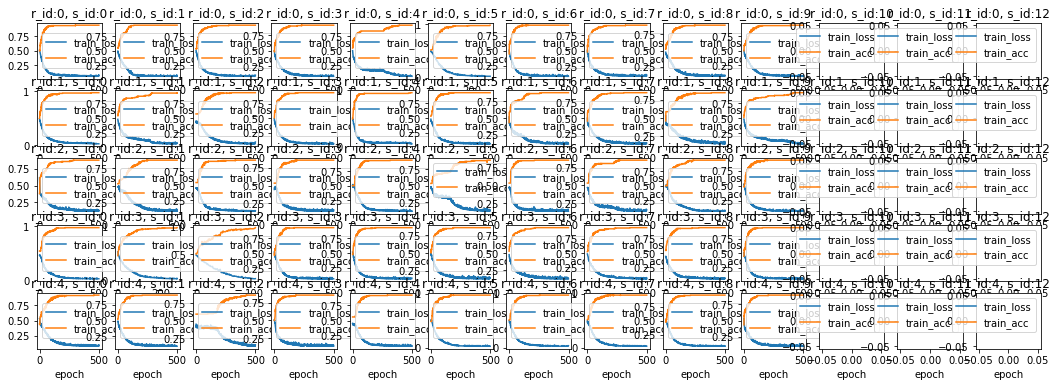

,r_id,m,s_id,epoch,train_loss,train_acc
0,0,100,0,0,0.524747,0.4200
1,0,100,0,1,0.505641,0.4700
2,0,100,0,2,0.486489,0.5300
3,0,100,0,3,0.484059,0.5100
4,0,100,0,4,0.489152,0.5400
...,...,...,...,...,...,...
341604,9,400,9,495,0.085449,0.9175
341605,9,400,9,496,0.085429,0.9175
341606,9,400,9,497,0.085390,0.9175
341607,9,400,9,498,0.085372,0.9175


In [3]:
train_file = 'results/ex1_mnist_l32_z50_s10_r10/train_file.csv'
train_df = pd.read_csv(train_file)

plot_all(train_df[train_df['m']==150], s_times=13, r_times=5)
train_df

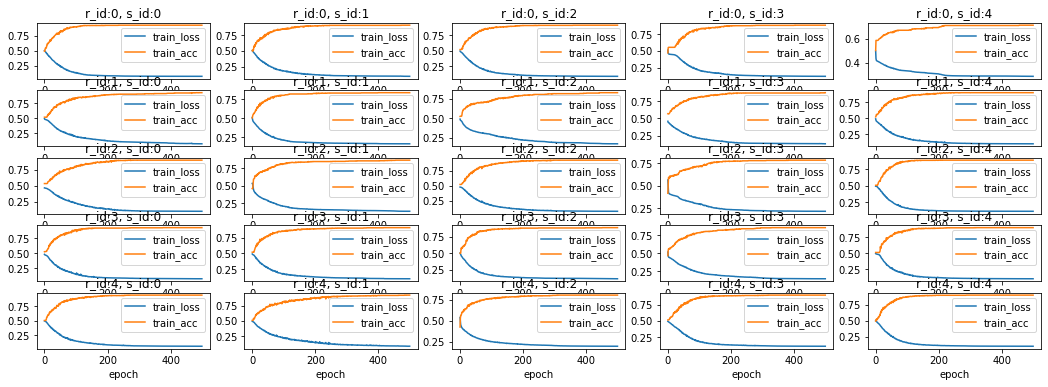

In [4]:
plot_all(train_df[train_df['m']==400], s_times=5, r_times=5)

In [5]:
train_df[(train_df['m']==400) & (train_df['epoch']==499)]

,r_id,m,s_id,epoch,train_loss,train_acc
29499,0,400,0,499,0.074078,0.9275
29999,0,400,1,499,0.097426,0.9050
30499,0,400,2,499,0.089560,0.9125
30999,0,400,3,499,0.119870,0.8825
31499,0,400,4,499,0.285974,0.7150
...,...,...,...,...,...,...
339608,9,400,5,499,0.104793,0.8975
340108,9,400,6,499,0.124914,0.8775
340608,9,400,7,499,0.107581,0.8950
341108,9,400,8,499,0.097774,0.9050


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,r_id,m,s_id,z_id,loss,label
0,0,100,0,6644,0.710917,0
1,0,100,0,9064,0.000245,0
2,0,100,0,7603,0.894132,1
3,0,100,0,5373,0.992401,0
4,0,100,0,11848,0.999157,1
...,...,...,...,...,...,...
34995,9,400,9,12252,0.011400,1
34996,9,400,9,5271,0.948019,1
34997,9,400,9,9262,0.000296,1
34998,9,400,9,6277,0.000366,0


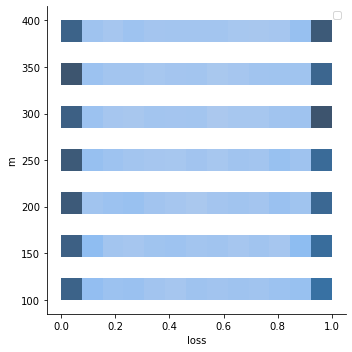

In [6]:
prob_file = 'results/ex1_mnist_l32_z50_s10_r10/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=None)

sns.displot(prob_df[(prob_df['r_id'] ==3)], x='loss', y='m')#, hue='m', element='step')
plt.legend()
prob_df

In [7]:
def var_s_of_f_given_zr(prob_df, r_id, z_id, m_list = None):

    if m_list is None:
        m_list = prob_df['m'].unique()
    var_s = []
    for m in m_list:
        temp_var_s = prob_df[(prob_df['r_id'] == r_id) & (prob_df['z_id']== z_id) & (prob_df['m']== m)]['loss']
        var_s.append(temp_var_s.var())
    return var_s, m_list


In [8]:
prob_df[prob_df['r_id'] == 1]

,r_id,m,s_id,z_id,loss,label
3500,1,100,0,12167,0.040355,0
3501,1,100,0,8771,0.967496,1
3502,1,100,0,6761,0.000807,1
3503,1,100,0,8564,0.003210,0
3504,1,100,0,1762,0.124869,0
...,...,...,...,...,...,...
6995,1,400,9,7582,0.999997,0
6996,1,400,9,10600,0.084106,0
6997,1,400,9,11474,0.000099,0
6998,1,400,9,81,1.000000,0


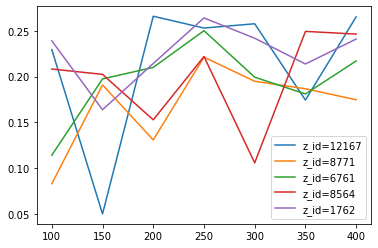

In [9]:


z_ids = prob_df[prob_df['r_id']==1]['z_id'].unique()
m_list = prob_df[prob_df['r_id']==1]['m'].unique()
var_s_z_list = []
for z_id in z_ids[:5]:
    var_s_z, _ = var_s_of_f_given_zr(prob_df, 1, z_id= z_id, m_list=m_list)
    var_s_z_list.append(var_s_z)
    plt.plot(m_list, var_s_z, label=f'z_id={z_id}')

plt.legend()


<AxesSubplot:xlabel='m', ylabel='loss'>

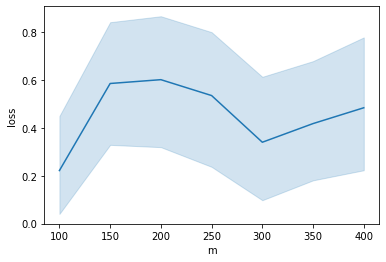

In [10]:
prob_df_filtered = prob_df[(prob_df['r_id'] == 1)&(prob_df['z_id'] == 6761)]

sns.lineplot(x = 'm', y='loss', data = prob_df_filtered )

In [28]:
prob_df

,r_id,m,s_id,z_id,loss,label
0,0,100,0,6644,0.710917,0
1,0,100,0,9064,0.000245,0
2,0,100,0,7603,0.894132,1
3,0,100,0,5373,0.992401,0
4,0,100,0,11848,0.999157,1
...,...,...,...,...,...,...
19095,5,250,1,11841,0.966898,1
19096,5,250,1,11314,0.150117,0
19097,5,250,1,12453,0.167342,1
19098,5,250,1,1060,0.216903,0


### exp1.2_mnist_l32_z50_s10_r10_same_z

In [11]:
## Get train_df
train_file = 'results/ex1.2_mnist_l32_z50_s10_r10_same_z/train_file.csv'
train_df = pd.read_csv(train_file)

# plot_all(train_df[train_df['m']==400], s_times=8, r_times=5)
train_df.head()

,r_id,m,s_id,epoch,train_loss,train_acc
0,0,100,0,0,0.537482,0.41
1,0,100,0,1,0.506326,0.49
2,0,100,0,2,0.476557,0.51
3,0,100,0,3,0.485416,0.54
4,0,100,0,4,0.494245,0.52


Text(0.5, 1.0, 'Train acc with increase in m')

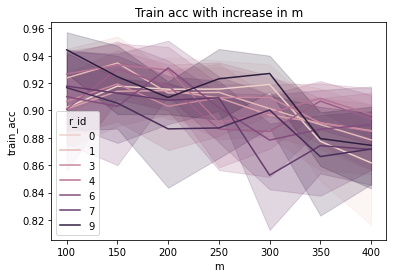

In [12]:
## Plot train accuracies
sns.lineplot(x ='m' , y='train_acc', data=train_df[(train_df['epoch']==499)], hue='r_id')
plt.title('Train acc with increase in m')
# plt.savefig('results/ex1.2_mnist_l32_z50_s10_r10_same_z/train_plot.png')

,r_id,m,s_id,z_id,loss,label
0,0,100,0,6644,0.973791,0
1,0,100,0,9064,0.000027,0
2,0,100,0,7603,0.982824,1
3,0,100,0,5373,0.997637,0
4,0,100,0,11848,0.999679,1
...,...,...,...,...,...,...
34995,9,400,9,12047,0.999994,1
34996,9,400,9,2436,0.999999,1
34997,9,400,9,2181,0.005851,0
34998,9,400,9,771,0.876376,0


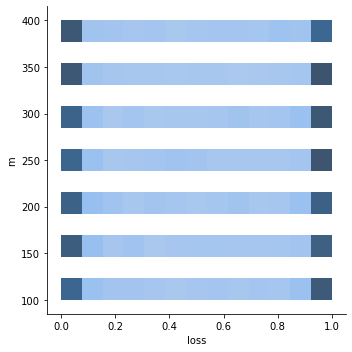

In [13]:
prob_file = 'results/ex1.2_mnist_l32_z50_s10_r10_same_z/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=None)

sns.displot(prob_df[(prob_df['r_id'] ==3)], x='loss', y='m')#, hue='m', element='step')
prob_df.head()

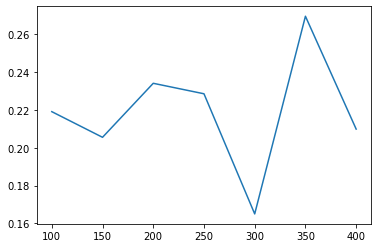

In [39]:
## var plot for a given z,rid across m
temp_prob_df = prob_df[(prob_df['r_id']==5) & (prob_df['z_id']==6644)]
m_list = prob_df['m'].unique()

var_f = []
for m in m_list:
    local_var = temp_prob_df[temp_prob_df['m']==m]['loss'].var()
    var_f.append(local_var)

plt.plot(m_list, var_f)

In [40]:
# INCORREXT, this is value of loss across m for given r and some z (Not value of Variance)

# prob_df_filtered = prob_df[(prob_df['r_id'] == 1)&(prob_df['z_id'] == 6644)]
# z_ids = prob_df['z_id'].unique()
# print(f'len of z: {len(z_ids)}')

# prob_df_filtered = prob_df[(prob_df['r_id'] == 1)&(prob_df['z_id'].isin(z_ids[:5]))]

# sns.lineplot(x = 'm', y='loss', data = prob_df_filtered, hue='z_id')

<AxesSubplot:xlabel='m', ylabel='var_s_given_mr'>

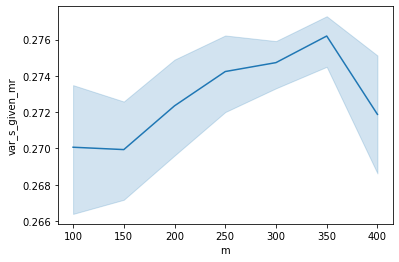

In [41]:
var_s_df = get_var_df(prob_df)
var_s_df.head()

sns.lineplot(x='m', y='var_s_given_mr', data=var_s_df)

### ex1.2__mnist_l32_z50_s10_r10_same_z_lr003

In [4]:
train_file = 'results/ex1.2_mnist_l32_z50_s10_r10_same_z_lr003/train_file.csv'
train_df = pd.read_csv(train_file)

# plot_all(train_df[train_df['m']==400], s_times=8, r_times=5)
train_df[train_df['epoch'] == 499].head()

,r_id,m,s_id,epoch,train_loss,train_acc
499,0,100,0,499,0.092590,0.94
999,0,100,1,499,0.077482,0.95
1499,0,100,2,499,0.077352,0.97
1999,0,100,3,499,0.061258,0.96
2765,0,100,5,499,0.087434,0.93


Text(0.5, 1.0, 'Train acc with increase in m')

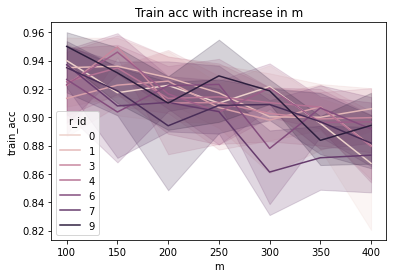

In [5]:
## Plot train accuracies
sns.lineplot(x ='m' , y='train_acc', data=train_df[(train_df['epoch']==499)], hue='r_id')
plt.title('Train acc with increase in m')
# plt.savefig('results/ex1.2_mnist_l32_z50_s10_r10_same_z/train_plot.png')

,r_id,m,s_id,z_id,loss,label
0,0,100,0,6644,0.884314,0
1,0,100,0,9064,0.002050,0
2,0,100,0,7603,0.950308,1
3,0,100,0,5373,0.985107,0
4,0,100,0,11848,0.996459,1


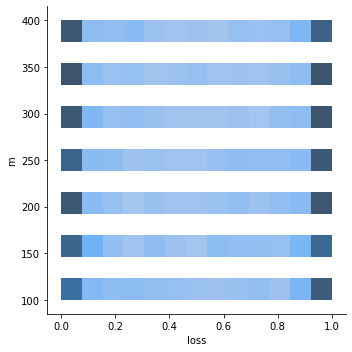

In [6]:
prob_file = 'results/ex1.2_mnist_l32_z50_s10_r10_same_z_lr003/prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=None)

sns.displot(prob_df[(prob_df['r_id'] ==3)], x='loss', y='m')#, hue='m', element='step')
prob_df.head()

<AxesSubplot:xlabel='m', ylabel='var_s_given_mr'>

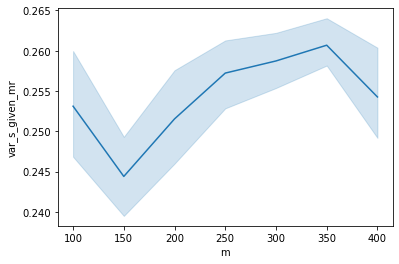

In [7]:
var_s_df = get_var_df(prob_df)
var_s_df.head()

sns.lineplot(x='m', y='var_s_given_mr', data=var_s_df)

### ex1.2__mnist_l64_z50_s10_r10_same_z_lr003

In [8]:
root_folder = 'results/ex1.2_mnist_l64_z50_s10_r10_same_z_lr003/'
train_file = root_folder + 'train_file.csv'
train_df = pd.read_csv(train_file)

# plot_all(train_df[train_df['m']==400], s_times=8, r_times=5)
train_df[train_df['epoch'] == 499]

,r_id,m,s_id,epoch,train_loss,train_acc
499,0,100,0,499,0.176221,0.8800
999,0,100,1,499,0.068724,0.9500
1499,0,100,2,499,0.111205,0.9600
2834,0,100,5,499,0.069198,0.9700
3334,0,100,6,499,0.104056,0.9000
...,...,...,...,...,...,...
342665,9,400,5,499,0.201065,0.8150
343165,9,400,6,499,0.162274,0.8575
343665,9,400,7,499,0.108792,0.9100
344165,9,400,8,499,0.074662,0.9475


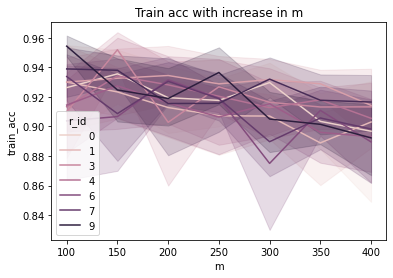

In [9]:
## Plot train accuracies
sns.lineplot(x ='m' , y='train_acc', data=train_df[(train_df['epoch']==499)], hue='r_id')
plt.title('Train acc with increase in m')
train_plot_file = root_folder + 'train_plot.png'
# plt.savefig( train_plot_file)
# print(f'fig saved at: {train_plot_file}')

from file: results/ex1.2_mnist_l64_z50_s10_r10_same_z_lr003/


,r_id,m,s_id,z_id,loss,label
0,0,100,0,6644,0.578127,0
1,0,100,0,9064,0.008791,0
2,0,100,0,7603,0.961875,1
3,0,100,0,5373,0.942343,0
4,0,100,0,11848,0.993204,1


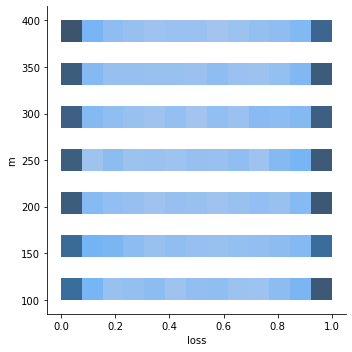

In [10]:
print('from file:', root_folder)
prob_file = root_folder + 'prob_file.csv'
prob_df = pd.read_csv(prob_file, index_col=None)

sns.displot(prob_df[(prob_df['r_id'] ==3)], x='loss', y='m')#, hue='m', element='step')
prob_df.head()

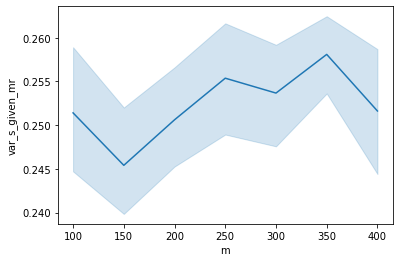

In [11]:
var_s_df = get_var_df(prob_df)
var_s_df.head()

var_f_plt = sns.lineplot(x='m', y='var_s_given_mr', data=var_s_df)
fig = var_f_plt.get_figure()
fig_path = root_folder + 'var_f_plot.png'
# fig.savefig(fig_path)
# print(f'plot saved at: {fig_path}')

### ex1.2__mnist_l128_lr003_mv1

In [46]:
root_folder = 'results/ex1.2_mnist_l128_lr003_mv1/'
train_file = root_folder + 'train_file.csv'
train_df = pd.read_csv(train_file)
# plot_all(train_df[train_df['m']==400], s_times=8, r_times=5)
train_df[train_df['epoch'] == 499]

,r_id,m,s_id,epoch,train_loss,train_acc
499,0,100,0,499,0.091937,0.93000
999,0,100,1,499,0.048748,0.97000
1499,0,100,2,499,0.135336,0.87000
1999,0,100,3,499,0.045391,0.97000
3205,0,100,6,499,0.143058,0.92000
...,...,...,...,...,...,...
243699,9,800,5,499,0.117320,0.90125
244199,9,800,6,499,0.099040,0.92250
244699,9,800,7,499,0.082034,0.93500
245199,9,800,8,499,0.127163,0.88875


fig saved at: ./results/ex1.2_mnist_l128_lr003_mv1/train_plot.png


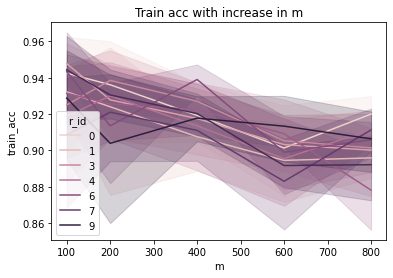

In [48]:
## Plot train accuracies
sns.lineplot(x ='m' , y='train_acc', data=train_df[(train_df['epoch']==499)], hue='r_id')
plt.title('Train acc with increase in m')
train_plot_file = root_folder + 'train_plot.png'
# plt.savefig( train_plot_file)
# print(f'fig saved at: ./{train_plot_file}')

for exp folder: results/ex1.2_mnist_l128_lr003_mv1/


,r_id,m,s_id,z_id,loss,label
0,0,100,0,6644,0.876857,0
1,0,100,0,9064,0.002215,0
2,0,100,0,7603,0.980384,1
3,0,100,0,5373,0.980078,0
4,0,100,0,11848,0.951752,1


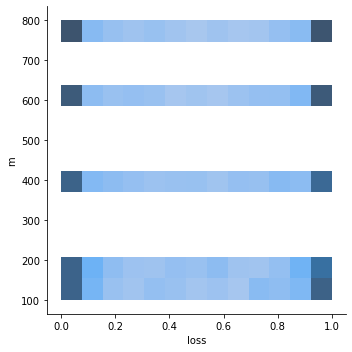

In [49]:
prob_file = root_folder + 'prob_file.csv'
print('for exp folder:', root_folder)
prob_df = pd.read_csv(prob_file, index_col=None)

sns.displot(prob_df[(prob_df['r_id'] ==3)], x='loss', y='m')#, hue='m', element='step')
prob_df.head()

plot saved at: ./results/ex1.2_mnist_l128_lr003_mv1/var_f_plot.png


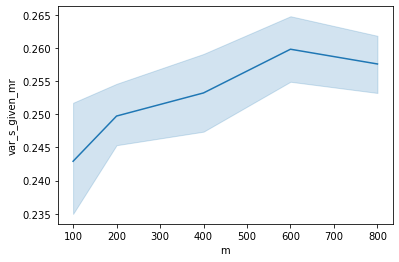

In [50]:
var_s_df = get_var_df(prob_df)
var_s_df.head()

var_f_plt = sns.lineplot(x='m', y='var_s_given_mr', data=var_s_df)
fig = var_f_plt.get_figure()
fig_path = root_folder + 'var_f_plot.png'
# fig.savefig(fig_path)
# print(f'plot saved at: ./{fig_path}')

<AxesSubplot:xlabel='m', ylabel='Gen error'>

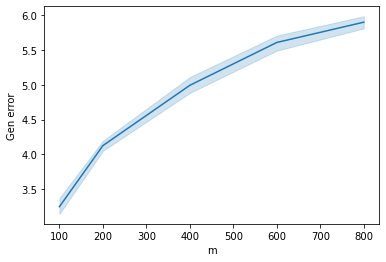

In [40]:
#Plot max_{z}{ (Var_{S}[f(r,S,z)]/m^{exp_m})log(m)^2 }
exp_m = 0.1
var_s_df = get_var_df(prob_df)
var_s_df['Gen error'] = (var_s_df['var_s_given_mr']/np.power(var_s_df['m'], exp_m))* np.log(var_s_df['m'])**2 
sns.lineplot(x='m', y='Gen error', data=var_s_df)

### ex1.2__mnist_l256_lr003_mv1

In [51]:
root_folder = 'results/ex1.2_mnist_l256_lr003_mv1/'
train_file = root_folder + 'train_file.csv'
train_df = pd.read_csv(train_file)
# plot_all(train_df[train_df['m']==400], s_times=8, r_times=5)
train_df[train_df['epoch'] == 499]

,r_id,m,s_id,epoch,train_loss,train_acc
499,0,100,0,499,0.092980,0.92000
999,0,100,1,499,0.047225,0.97000
2189,0,100,5,499,0.090597,0.95000
2689,0,100,6,499,0.092616,0.91000
3189,0,100,7,499,0.079848,0.96000
...,...,...,...,...,...,...
242121,9,800,5,499,0.129138,0.88875
242621,9,800,6,499,0.081489,0.93875
243121,9,800,7,499,0.065197,0.95375
243621,9,800,8,499,0.125260,0.88875


fig saved at: ./results/ex1.2_mnist_l256_lr003_mv1/train_plot.png


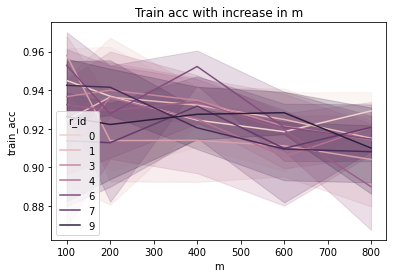

In [53]:
## Plot train accuracies
sns.lineplot(x ='m' , y='train_acc', data=train_df[(train_df['epoch']==499)], hue='r_id')
plt.title('Train acc with increase in m')
train_plot_file = root_folder + 'train_plot.png'
# plt.savefig( train_plot_file)
# print(f'fig saved at: ./{train_plot_file}')

In [54]:
prob_file = root_folder + 'prob_file.csv'
print('for exp folder:', root_folder)
prob_df = pd.read_csv(prob_file, index_col=None)

# sns.displot(prob_df[(prob_df['r_id'] ==1)], x='loss', y='m')#, hue='m', element='step')
prob_df.tail()

for exp folder: results/ex1.2_mnist_l256_lr003_mv1/


,r_id,m,s_id,z_id,loss,label
24995,9,800,9,12047,0.055064,1
24996,9,800,9,2436,0.983674,1
24997,9,800,9,2181,0.270622,0
24998,9,800,9,771,0.066612,0
24999,9,800,9,12267,0.006585,1


plot saved at: ./results/ex1.2_mnist_l256_lr003_mv1/var_f_plot.png


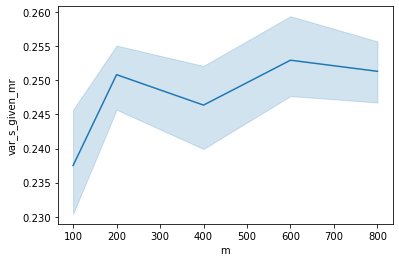

In [55]:
var_s_df = get_var_df(prob_df)
var_s_df.head()

var_f_plt = sns.lineplot(x='m', y='var_s_given_mr', data=var_s_df)
fig = var_f_plt.get_figure()
fig_path = root_folder + 'var_f_plot.png'
# fig.savefig(fig_path)
# print(f'plot saved at: ./{fig_path}')

<AxesSubplot:xlabel='m', ylabel='var_s_given_mr'>

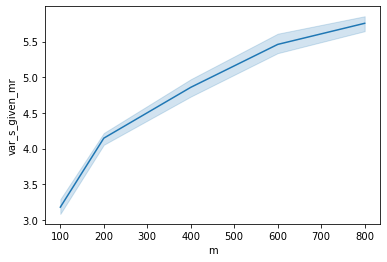

In [16]:
exp_m = 0.1
var_s_df = get_var_df(prob_df)
var_s_df['var_s_given_mr'] = (var_s_df['var_s_given_mr']/np.power(var_s_df['m'], exp_m))* np.log(var_s_df['m'])**2 
sns.lineplot(x='m', y='var_s_given_mr', data=var_s_df)

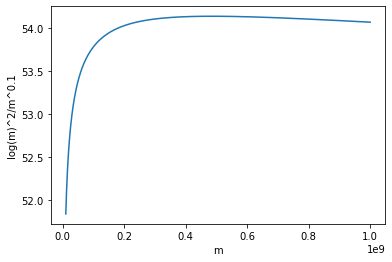

In [45]:
alpha = 0.1
m_s = np.array(range(100,10000))*100000
y = (np.log(m_s)**2)/np.power(m_s, alpha)

plt.plot(m_s, y)
plt.xlabel('m')
plt.ylabel('log(m)^2/m^0.1')
plt.show()

# Moving to directly calculating gradients

### What we need
$$\| \nabla_{W} f(r,S,z)\| \leq L_g, \forall z \in D$$
$$\| \nabla_{W} f(W_{\tau m},z)\| \leq L_g, \forall z \in D$$
So I can calculate worst gradient over z
and then take expectation over r and S?


In [3]:
## Some related functions
def get_fro_norm(prob_df):
    cols =['fro0','fro1','fro2','fro3']
    prob_df['f_norm'] = 0
    for col in cols:
        prob_df['f_norm'] += prob_df[col]**2
    prob_df['f_norm'] = np.sqrt(prob_df['f_norm'])
    # return prob_df

def get_spe_norm(prob_df):
    cols =['spe0','spe2']
    prob_df['s_norm'] = 1
    for col in cols:
        prob_df['s_norm'] *= prob_df[col]

def get_avg_grads(prob_df):

    ## Given r,m,s pick top z with max norm values
    avg_over_s = {}
    avg_over_s['m'] = []
    avg_over_s['r_id'] = []
    avg_over_s['f_norm'] = []
    avg_over_s['s_norm'] = []

    ## Pick worst z values
    max_norms_perS = prob_df.groupby(['r_id', 'm','s_id'], as_index=False)['f_norm', 's_norm'].max()
    r_ids = max_norms_perS['r_id'].unique()
    m_list = max_norms_perS['m'].unique()
    for r_id in r_ids:
        for m in m_list:
            temp_df = max_norms_perS[(max_norms_perS['r_id']==r_id) &(max_norms_perS['m']==m)]
            # print('temp df', temp_df)
            avg_over_s['m'].append(m)
            avg_over_s['r_id'].append(r_id)

            avg_f_norm = temp_df['f_norm'].mean()
            avg_s_norm = temp_df['s_norm'].mean()
            avg_over_s['f_norm'].append(avg_f_norm)
            avg_over_s['s_norm'].append(avg_s_norm)
    return pd.DataFrame(avg_over_s)

### ex2_mnist_l128_lr003_b8_mv2

In [4]:
root_folder = 'results/ex2_mnist_l128_lr003_b8_mv2/'
train_file = root_folder + 'train_file.csv'
train_df = pd.read_csv(train_file)
# plot_all(train_df[train_df['m']==400], s_times=8, r_times=5)
train_df[train_df['epoch'] == 499]

,r_id,m,s_id,epoch,train_loss,train_acc
499,0,100,0,499,0.129198,0.870000
999,0,100,1,499,0.035068,0.970000
1499,0,100,2,499,0.113870,0.890000
1999,0,100,3,499,0.044536,0.960000
2629,0,200,0,499,0.074031,0.930000
...,...,...,...,...,...,...
191752,9,1400,0,499,0.106542,0.898571
192252,9,1400,1,499,0.129514,0.875000
192752,9,1400,2,499,0.119184,0.885000
193252,9,1400,3,499,0.105888,0.897857


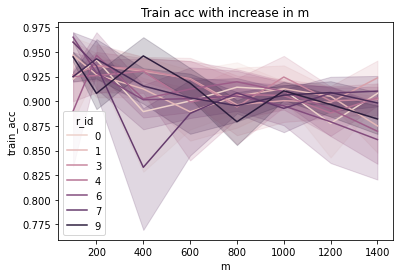

In [5]:
## Plot train accuracies
sns.lineplot(x ='m' , y='train_acc', data=train_df[(train_df['epoch']==499)], hue='r_id')
plt.title('Train acc with increase in m')
train_plot_file = root_folder + 'train_plot.png'
# plt.savefig( train_plot_file)
# print(f'fig saved at: ./{train_plot_file}')

In [6]:
prob_file = root_folder + 'prob_file.csv'
print(f'prob file: ./{prob_file}')
prob_df = pd.read_csv(prob_file, index_col=None)

# sns.displot(prob_df[(prob_df['r_id'] ==1)], x='loss', y='m')#, hue='m', element='step')
get_fro_norm(prob_df)
get_spe_norm(prob_df)
prob_df.tail()

prob file: ./results/ex2_mnist_l128_lr003_b8_mv2/prob_file.csv


,r_id,m,s_id,z_id,loss,label,fro0,fro1,fro2,fro3,spe0,spe2,f_norm,s_norm
19995,9,1400,4,12047,2.193451e-05,1,0.006417,0.000566,0.000637,0.000186,0.006417,0.000637,0.006476,4.090223e-06
19996,9,1400,4,2436,2.312589e-01,1,26.358662,4.258067,2.734858,1.508498,26.358603,2.734858,26.882433,7.208704e+01
19997,9,1400,4,2181,4.612905e-02,0,12.732970,1.175117,1.246586,0.373362,12.732947,1.246586,12.853124,1.587271e+01
19998,9,1400,4,771,2.384186e-07,0,0.000042,0.000006,0.000005,0.000002,0.000042,0.000005,0.000043,1.927038e-10
19999,9,1400,4,12267,5.784329e-01,1,51.262978,6.196327,5.700752,2.069121,51.262932,5.700752,51.991030,2.922372e+02


/tmp/ipykernel_3373/1362032202.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_norms_perS = prob_df.groupby(['r_id', 'm','s_id'], as_index=False)['f_norm', 's_norm'].max()


img saved at : ./results/ex2_mnist_l128_lr003_b8_mv2/lg_fnorm_img.png


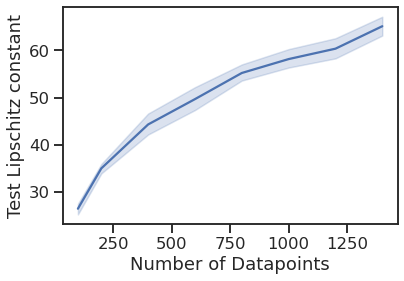

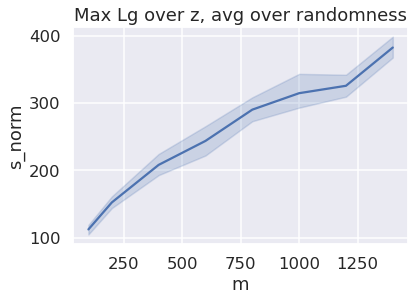

In [8]:
avg_grads = get_avg_grads(prob_df)
# print(avg_grads.head())

sns.set_theme()
## Applying locally
with sns.axes_style('ticks'):
    sns.set_context('talk')
    sns.lineplot(x='m', y='f_norm', data=avg_grads)
    # plt.title('Max Lg over z, avg over randomness')
    plt.ylabel('Test Lipschitz constant')
    plt.xlabel('Number of Datapoints')
    lg_fnorm_path = root_folder + 'lg_fnorm_img.png'
    plt.savefig(lg_fnorm_path, bbox_inches='tight', dpi=300)
    print(f'img saved at : ./{lg_fnorm_path}')
    plt.show()

sns.lineplot(x='m', y='s_norm', data=avg_grads)
plt.title('Max Lg over z, avg over randomness')
plt.show()

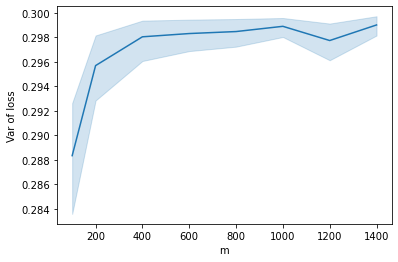

In [34]:
var_s_df = get_var_df(prob_df)
var_s_df.head()

var_f_plt = sns.lineplot(x='m', y='var_s_given_mr', data=var_s_df)
plt.ylabel('Var of loss')
fig = var_f_plt.get_figure()
fig_path = root_folder + 'var_f_plot.png'
# fig.savefig(fig_path)
# print(f'plot saved at: ./{fig_path}')

#### Tryiniig Regression fit

In [55]:
get_avg_grads(prob_df).groupby('m')['f_norm'].mean().to_frame().reset_index()

/tmp/ipykernel_27503/1362032202.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_norms_perS = prob_df.groupby(['r_id', 'm','s_id'], as_index=False)['f_norm', 's_norm'].max()


,m,f_norm
0,100,26.396279
1,200,34.957440
2,400,44.284737
3,600,49.660169
4,800,55.207668
5,1000,58.160039
6,1200,60.367217
7,1400,65.135410


/tmp/ipykernel_27503/1362032202.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_norms_perS = prob_df.groupby(['r_id', 'm','s_id'], as_index=False)['f_norm', 's_norm'].max()


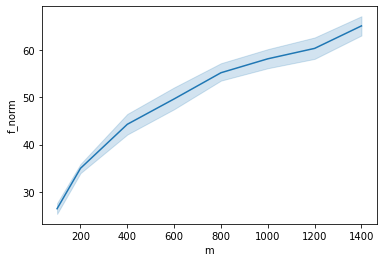

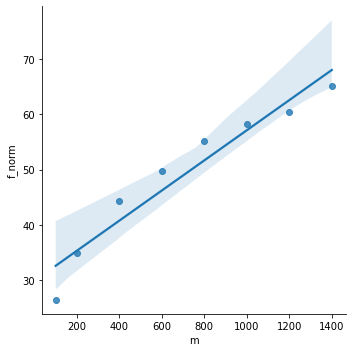

In [61]:
avg_grads = get_avg_grads(prob_df)

sns.lineplot(x='m', y='f_norm', data=avg_grads)
# sns.lmplot(x='m', y='f_norm',order=0.5, data= pd.DataFrame(avg_grads.groupby('m')['f_norm'].mean().to_frame().reset_index()))

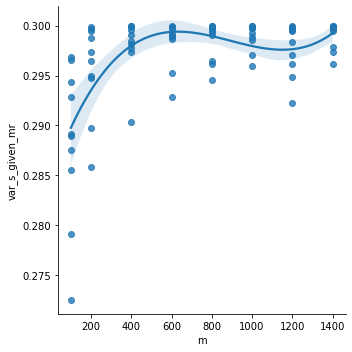

In [40]:
var_s_df = get_var_df(prob_df)

# var_f_plt = sns.regplot(x='m', y='var_s_given_mr', data=var_s_df)
var_f_plt = sns.lmplot(x='m', y='var_s_given_mr', data=var_s_df, order=3)

#### Other minor plots, not needed

Text(0.5, 1.0, 'Gradients, i.e. avg over r,s and z')

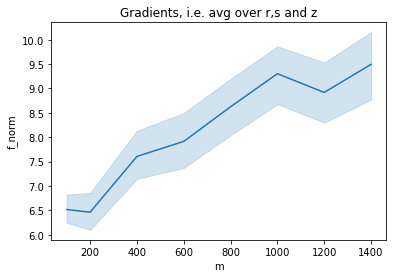

In [27]:
sns.lineplot(x='m', y='f_norm', data=prob_df)
plt.title('Gradients, i.e. avg over r,s and z')

In [28]:
max_norms_perS = prob_df.groupby(['r_id', 'm', 's_id'], as_index=False)['f_norm', 's_norm'].max()
max_norms_perS

/tmp/ipykernel_76544/3691795075.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_norms_perS = prob_df.groupby(['r_id', 'm', 's_id'], as_index=False)['f_norm', 's_norm'].max()


,r_id,m,s_id,f_norm,s_norm
0,0,100,0,25.461632,103.666408
1,0,100,1,32.178727,138.344969
2,0,100,2,29.675199,152.034710
3,0,100,3,30.515452,147.549204
4,0,100,4,23.163567,104.401644
...,...,...,...,...,...
395,9,1400,0,58.000277,266.169807
396,9,1400,1,50.250184,300.679477
397,9,1400,2,57.002753,338.042208
398,9,1400,3,74.770413,510.703511


Text(0.5, 1.0, 'Avg gradients over S and r, max over z, not main')

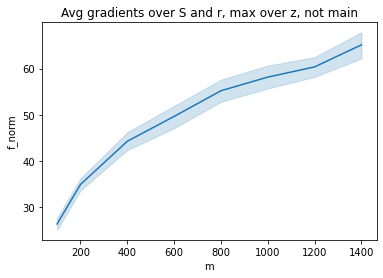

In [29]:
sns.lineplot(x='m', y='f_norm', data = max_norms_perS)
plt.title('Avg gradients over S and r, max over z, not main')

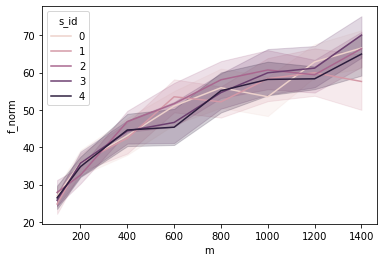

<AxesSubplot:xlabel='m', ylabel='s_norm'>

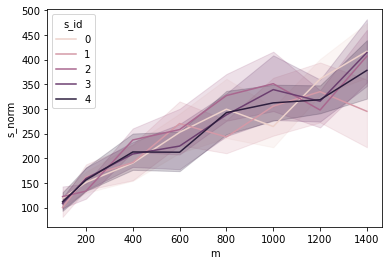

In [31]:
sns.lineplot(x='m', y='f_norm', data = max_norms_perS, hue='s_id')
plt.show()
sns.lineplot(x='m', y='s_norm', data = max_norms_perS, hue='s_id')


### ex2_mnist_l128_lr003_b8_mv2_g
i.e. Good distribution (Non random case)

In [9]:
root_folder = 'results/ex2_mnist_l128_lr003_b8_mv2_g/'
train_file = root_folder + 'train_file.csv'
train_df = pd.read_csv(train_file)
# plot_all(train_df[train_df['m']==400], s_times=8, r_times=5)
train_df

,r_id,m,s_id,epoch,train_loss,train_acc
0,0,100,0,0,0.395638,0.770000
1,0,100,0,1,0.211550,0.970000
2,0,100,0,2,0.124694,1.000000
3,0,100,1,0,0.378015,0.910000
4,0,100,1,1,0.196733,0.990000
...,...,...,...,...,...,...
769,9,1400,1,1,0.015280,0.995714
770,9,1400,2,0,0.072552,0.980714
771,9,1400,3,0,0.072907,0.982857
772,9,1400,4,0,0.073234,0.978571


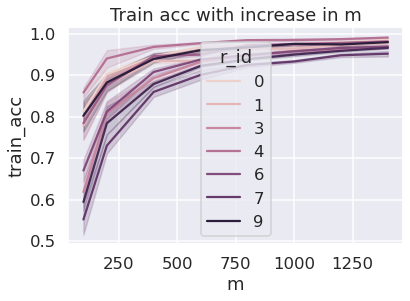

In [10]:
## Plot train accuracies
sns.lineplot(x ='m' , y='train_acc', data=train_df[(train_df['epoch']==0)], hue='r_id')
plt.title('Train acc with increase in m')
train_plot_file = root_folder + 'train_plot.png'
# plt.savefig( train_plot_file)
# print(f'fig saved at: ./{train_plot_file}')

In [11]:
prob_file = root_folder + 'prob_file.csv'
print(f'prob file: ./{prob_file}')
prob_df = pd.read_csv(prob_file, index_col=None)

# sns.displot(prob_df[(prob_df['r_id'] ==1)], x='loss', y='m')#, hue='m', element='step')
get_fro_norm(prob_df)
get_spe_norm(prob_df)
prob_df.tail()

prob file: ./results/ex2_mnist_l128_lr003_b8_mv2_g/prob_file.csv


,r_id,m,s_id,z_id,loss,label,fro0,fro1,fro2,fro3,spe0,spe2,f_norm,s_norm
19995,9,1400,4,9109,0.000046,0,0.002449,0.000207,0.001400,0.000394,0.002449,0.001400,0.002855,0.000003
19996,9,1400,4,260,0.000979,1,0.033243,0.004713,0.017733,0.008298,0.033243,0.017733,0.038867,0.000589
19997,9,1400,4,10475,0.000633,1,0.026793,0.003158,0.013308,0.005367,0.026793,0.013308,0.030557,0.000357
19998,9,1400,4,8712,0.002472,1,0.071387,0.011271,0.037143,0.020926,0.071387,0.037143,0.083909,0.002652
19999,9,1400,4,6619,0.000070,0,0.003634,0.000311,0.001965,0.000593,0.003634,0.001965,0.004186,0.000007


/tmp/ipykernel_3373/1362032202.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_norms_perS = prob_df.groupby(['r_id', 'm','s_id'], as_index=False)['f_norm', 's_norm'].max()


img saved at : ./results/ex2_mnist_l128_lr003_b8_mv2_g/lg_fnorm_img.png


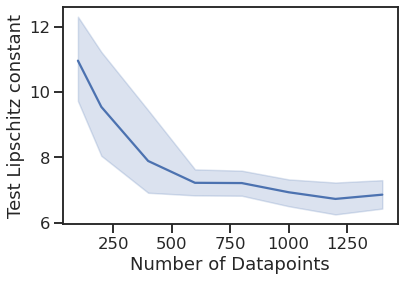

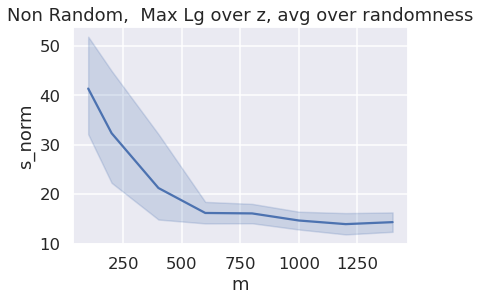

In [12]:
avg_grads = get_avg_grads(prob_df)
# print(avg_grads.head())

sns.set_theme()
## Applying locally
with sns.axes_style('ticks'):
    sns.set_context('talk')
    sns.lineplot(x='m', y='f_norm', data=avg_grads)
    # plt.title('Max Lg over z, avg over randomness')
    plt.ylabel('Test Lipschitz constant')
    plt.xlabel('Number of Datapoints')
    lg_fnorm_path = root_folder + 'lg_fnorm_img.png'
    plt.savefig(lg_fnorm_path, bbox_inches='tight', dpi=300)
    print(f'img saved at : ./{lg_fnorm_path}')
    plt.show()

# sns.lineplot(x='m', y='f_norm', data=avg_grads)
# plt.title('Non Random, Max Lg over z, avg over randomness')
# plt.ylabel('Lg')
# lg_fnorm_path = root_folder + 'lg_fnorm_img.png' 
# # plt.savefig(lg_fnorm_path)
# # print(f'fig saved at :./{lg_fnorm_path}')
# plt.show()

sns.lineplot(x='m', y='s_norm', data=avg_grads)
plt.title('Non Random,  Max Lg over z, avg over randomness')
plt.show()

plot saved at: ./results/ex2_mnist_l128_lr003_b8_mv2_g/var_f_plot.png


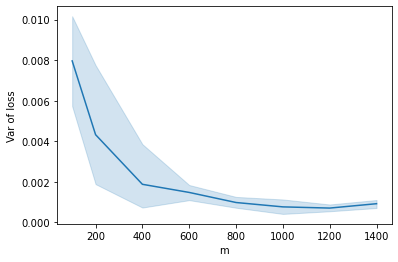

In [19]:
var_s_df = get_var_df(prob_df)
var_s_df.head()

var_f_plt = sns.lineplot(x='m', y='var_s_given_mr', data=var_s_df)
plt.ylabel('Var of loss')
fig = var_f_plt.get_figure()
fig_path = root_folder + 'var_f_plot.png'
# fig.savefig(fig_path)
# print(f'plot saved at: ./{fig_path}')

#### Trying regression fit

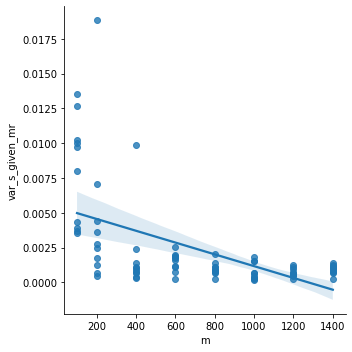

In [21]:
var_s_df = get_var_df(prob_df)

# var_f_plt = sns.regplot(x='m', y='var_s_given_mr', data=var_s_df)
var_f_plt = sns.lmplot(x='m', y='var_s_given_mr', data=var_s_df)

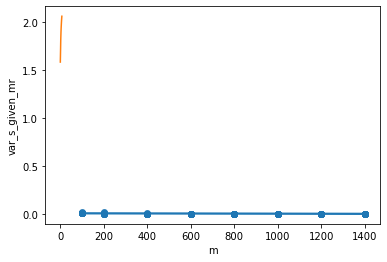

In [29]:
var_s_df = get_var_df(prob_df)

var_f_plt = sns.regplot(x='m', y='var_s_given_mr', data=var_s_df, order=-1)

m_list = var_s_df['m'].unique()
order = 0.1
plt.plot(m_list**order)
